# Model Development

In this notebook, we will be developing predictive models using the `Telco Customer Churn` dataset. Using `sklearn` models: Logistic Regression, Decision Tree, and K-Nearest Neighbors; we will craft various classifiers as base models and then to optimize using the cost function, regularization and hyperparameter tuning.

By the end of this notebook, we will establish foundations for evaluating which model will perform best for predicting churn.

## Loading Tools and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/encoded_telco_churn.csv')
df

,Male,Partner,Dependents,SeniorCitizen,DurationMonths,PhoneService,MultipleLines,NoInternet,DSLInternet,FiberOpticInternet,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyContract,AnnualContract,BiannualContract,AutoBankTransfer,AutoCreditCard,ElectronicCheck,MailedCheck,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,56.95,"1,889.50",0
2,1,0,0,0,2,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,42.30,"1,840.75",0
4,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,1,1,0,24,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,0,0,1,1,84.80,"1,990.50",0
7028,0,1,1,0,72,1,1,0,0,1,0,1,1,0,1,1,0,1,0,0,1,0,0,1,103.20,"7,362.90",0
7029,0,1,1,0,11,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,29.60,346.45,0
7030,1,1,0,1,4,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,74.40,306.60,1


## Logistic Regression

In [2]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
logreg_base = LogisticRegression()
logreg_base.fit(X_train, y_train)

LogisticRegression()

In [4]:
logreg_ypred = logreg_base.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_ypred)

logreg_ypred_proba = logreg_base.predict_proba(X_test)
logreg_logloss = log_loss(y_test, logreg_ypred_proba)

In [5]:
print(logreg_accuracy)
print(logreg_logloss)

0.7995260663507109
0.4267458602629152


## Logistic Regression with C Regularization

#### Testing To Find Best `Regularization Strength C`

In [6]:
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
cv_scores = []
cv_scores_std = []

for c in C_list:
    logreg = LogisticRegression(C=c, random_state=42)
    cv_loop_results = cross_validate(
                                    X=X_train,
                                    y=y_train,
                                    estimator=logreg,
                                    cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [7]:
cv_scores, cv_scores_std

([0.8889565147353511,
  0.8908933860500418,
  0.8975958732830218,
  0.8965474637478792,
  0.8956536678585652,
  0.8955395227568959,
  0.8959912596229841,
  0.8956450425771989],
 [0.009112406529670347,
  0.00946892126529175,
  0.009412477540773845,
  0.011747924946154079,
  0.010655023699343985,
  0.010695955860371757,
  0.010852702249545364,
  0.011313271924044204])

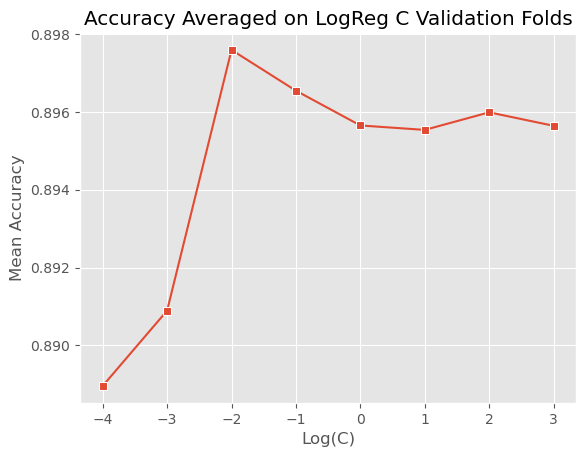

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x = np.log10(C_list), y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Log(C)')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy Averaged on LogReg C Validation Folds')
plt.show()

Regularization Strength `C=1e-2` average cross-validation score is almost 0.898

#### After Finding the Best `Regularization Strength C`

In [9]:
logreg_best = LogisticRegression(C=1e-2)
logreg_best.fit(X_train, y_train)

LogisticRegression(C=0.01)

In [10]:
logbest_ypred = logreg_best.predict(X_test)
logbest_accuracy = accuracy_score(y_test, logbest_ypred)
logbest_ypred_proba = logreg_best.predict_proba(X_test)
logbest_logloss = log_loss(y_test, logbest_ypred_proba)

In [11]:
print(logbest_accuracy)
print(logbest_logloss)

0.7943127962085308
0.43089468719841745


`Scores` resulted in being slightly `less` than the `base model`.

## Decision Tree

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [13]:
dtree_base = DecisionTreeClassifier()
dtree_base.fit(X_train, y_train)

DecisionTreeClassifier()

In [14]:
dtree_ypred = dtree_base.predict(X_test)
dtree_accuracy = accuracy_score(y_test, dtree_ypred)
dtree_report = classification_report(y_test, dtree_ypred)

In [15]:
print(dtree_accuracy)
print(dtree_report)

0.7293838862559242
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1549
           1       0.49      0.50      0.50       561

    accuracy                           0.73      2110
   macro avg       0.65      0.66      0.66      2110
weighted avg       0.73      0.73      0.73      2110



## Decision Tree with Tuning

#### `max_depth` Hyperparameter Tuning

In [16]:
max_depth_list = [10, 20, 30, 40, 50]
cv_scores = []
cv_scores_std = []

for depth in max_depth_list:
    dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    cv_loop_results = cross_validate(
                                X=X_train,
                                y=y_train,
                                estimator=dtree,
                                cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [17]:
best_depth = {'max_depth':max_depth_list, 'cv_scores':cv_scores, 'cv_scores_std':cv_scores_std}
best_depth = pd.DataFrame(best_depth)
best_depth

,max_depth,cv_scores,cv_scores_std
0,10,0.87,0.01
1,20,0.86,0.01
2,30,0.86,0.01
3,40,0.86,0.01
4,50,0.86,0.01


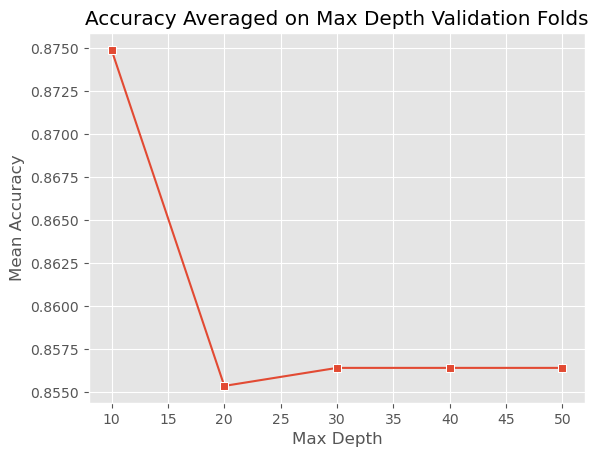

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x = max_depth_list, y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy Averaged on Max Depth Validation Folds')
plt.show()

Best `max_depth` is `10` with an accuracy score of almost 0.875.

#### `min_samples_split` Hyperparameter Tuning

In [19]:
min_samples_split_list = [10, 20, 50, 75, 100]
cv_scores = []
cv_scores_std = []

for split in min_samples_split_list:
    dtree = DecisionTreeClassifier(min_samples_split=split, random_state=42)
    cv_loop_results = cross_validate(
                                X=X_train,
                                y=y_train,
                                estimator=dtree,
                                cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [20]:
best_split = {'min_samples_split':min_samples_split_list, 'cv_scores':cv_scores, 'cv_scores_std':cv_scores_std}
best_split = pd.DataFrame(best_split)
best_split

,min_samples_split,cv_scores,cv_scores_std
0,10,0.86,0.01
1,20,0.87,0.01
2,50,0.89,0.01
3,75,0.89,0.01
4,100,0.89,0.01


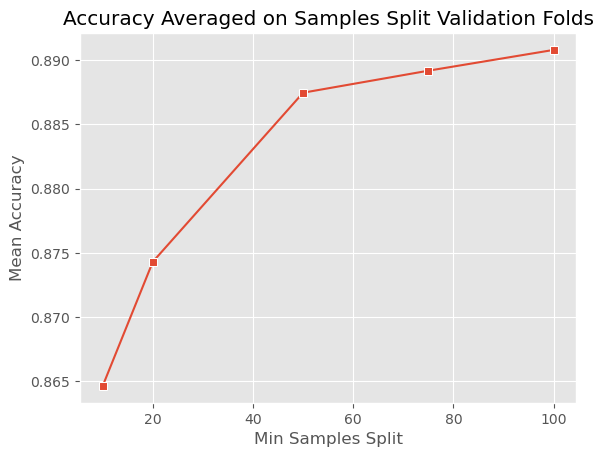

In [21]:
fig, ax = plt.subplots()
sns.lineplot(x = min_samples_split_list, y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Min Samples Split')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy Averaged on Samples Split Validation Folds')
plt.show()

Best `min_samples_split` is `100` with an accuracy score of above 0.89.

#### `min_samples_leafs` Hyperparameter Tuning

In [22]:
min_samples_leaf_list = [10, 20, 50, 75, 100]
cv_scores = []
cv_scores_std = []

for leaf in min_samples_leaf_list:
    dtree = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    cv_loop_results = cross_validate(
                                X=X_train,
                                y=y_train,
                                estimator=dtree,
                                cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [23]:
best_leaf = {'min_samples_split':min_samples_leaf_list, 'cv_scores':cv_scores, 'cv_scores_std':cv_scores_std}
best_leaf = pd.DataFrame(best_leaf)
best_leaf

,min_samples_split,cv_scores,cv_scores_std
0,10,0.88,0.01
1,20,0.89,0.01
2,50,0.89,0.01
3,75,0.89,0.01
4,100,0.89,0.01


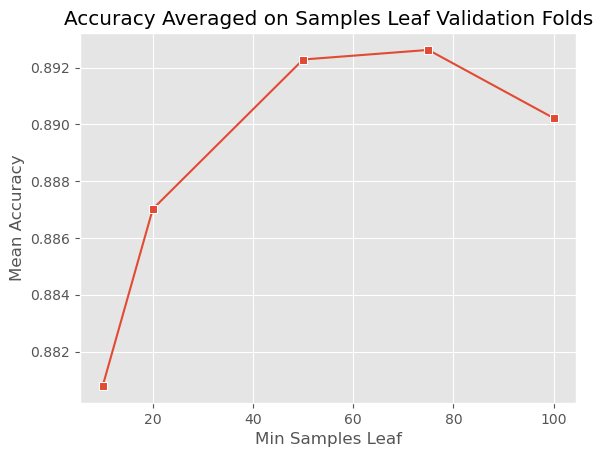

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x = min_samples_leaf_list, y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Min Samples Leaf')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy Averaged on Samples Leaf Validation Folds')
plt.show()

Best `min_samples_leaf` is `75` with an accuracy score of above 0.89.

#### `criterion` Hyperparameter Tuning

In [25]:
criterion_list = ['gini', 'entropy', 'log_loss']
cv_scores = []
cv_scores_std = []

for criteria in criterion_list:
    dtree = DecisionTreeClassifier(criterion=criteria, random_state=42)
    cv_loop_results = cross_validate(
                                X=X_train,
                                y=y_train,
                                estimator=dtree,
                                cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [26]:
best_criterion = {'criterion':criterion_list, 'cv_scores':cv_scores, 'cv_scores_std':cv_scores_std}
best_criterion = pd.DataFrame(best_criterion)
best_criterion

,criterion,cv_scores,cv_scores_std
0,gini,0.86,0.01
1,entropy,0.86,0.00
2,log_loss,0.86,0.00


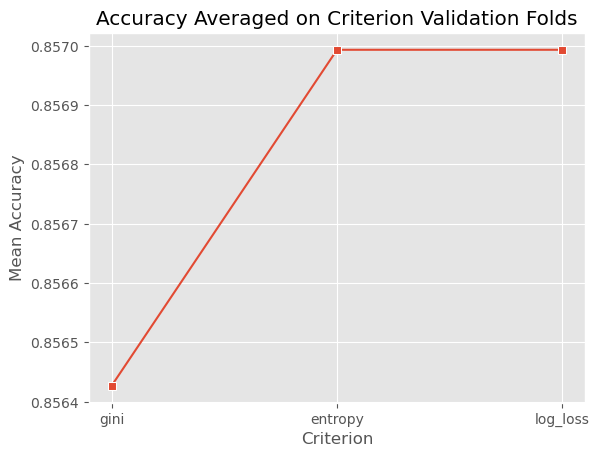

In [27]:
fig, ax = plt.subplots()
sns.lineplot(x = criterion_list, y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Criterion')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy Averaged on Criterion Validation Folds')
plt.show()

Best `criterion` is `entropy` with an accuracy score of almost 0.85.

#### Summary of `Best Hyperparameter` Tuning for Decision Tree
- `max_depth` is 10
- `min_samples_split` is 100
- `min_samples_leaf` is 75
- `criterion` is entropy

## Script

In [28]:
try:
    print('Script Executed Successfully')
except:
    print('FAILED')

Script Executed Successfully
